# Q* Learning - FrozenLake
<br> 
In this Notebook, we'll implement an agent <b>that plays FrozenLake.</b>
<img src="https://www.gymlibrary.ml/_images/frozen_lake.gif" alt="Frozen Lake"/>

The goal of this game is <b>to go from the starting state (S) to the goal state (G)</b> by walking only on frozen tiles (F) and avoid holes (H).However, the ice is slippery, <b>so you won't always move in the direction you intend (stochastic environment)</b>


Reference: code adapted from 
https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Q%20learning/FrozenLake/Q%20Learning%20with%20FrozenLake.ipynb

In [1]:
!pip install gymnasium

     ---------------------------------------- 0.0/925.5 kB ? eta -:--:--
     ------ ------------------------------- 153.6/925.5 kB 4.6 MB/s eta 0:00:01
     ---------------- --------------------- 409.6/925.5 kB 5.1 MB/s eta 0:00:01
     ----------------------------- -------- 727.0/925.5 kB 5.7 MB/s eta 0:00:01
     -------------------------------------- 925.5/925.5 kB 5.3 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import gymnasium as gym 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from tqdm import tqdm

**gym**  

```gym.envs.registry.values()``` shows all available environments  

*Methods*  
```gym.make()``` chooses universe  
```env.reset()``` starts the game  
```env.step(action)``` takes a step and returns ```(observation, reward, done, terminated, info)```  
```env.seed()``` initializes random state

*Attributes*  
```gym.Env.action_space``` available actions  
```gym.Env.reward_range``` rewards

In [5]:
env = gym.make('FrozenLake-v1', is_slippery=True, render_mode='rgb_array')

In [6]:
env.metadata
env.spec
env.desc

print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")
print(f"Reward range: {env.reward_range}")

Action space: Discrete(4)
Observation space: Discrete(16)
Reward range: (0, 1)


## Create the Q-table and initialize it 

In [7]:
n_action = env.action_space.n
n_state = env.observation_space.n

Q = np.zeros((n_state, n_action))
Q

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

## Set the hyperparameters

In [14]:
n_epoch = 5000
n_step = 99

learning_rate = 0.1
gamma_rate = 0.95                  # Discounting rate

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.005            # Exponential decay rate for exploration prob

## The Q learning algorithm
- Now we implement the Q learning algorithm:
<img src="https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Q%20learning/FrozenLake/qtable_algo.png?raw=1" alt="Q algo"/>

$ Q^{new}(S_t, A_t) = Q(S_t, A_t) + \alpha . (R_{t+1} + \gamma . max_aQ(S_{t+1}, a) - Q(S_t,A_t)) $

In [21]:
rewards = []

for _epoch in tqdm(range(n_epoch)):

    state, _ = env.reset()
    epoch_reward = 0
    
    for _ in range(n_step):

        # Define action / epsilon-greedy strategy
        exploration_or_exploitation = random.uniform(0, 1)
        
        if exploration_or_exploitation > epsilon:
            action = np.argmax(Q[state,:])
        else:
            action = env.action_space.sample()

        # Take action
        new_state, new_reward, terminated, _, _ = env.step(action)

        # Update Q
        Q[state,action] = Q[state,action] + learning_rate * (new_reward + gamma_rate * np.max(Q[new_state,:]) - Q[state,action])
        
        epoch_reward += new_reward
        state = new_state
        
        if terminated: break
        
    # Schedule to reduce epsilon
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*_epoch) 
    rewards.append(epoch_reward)

print("Score over time: " +  str(sum(rewards)/n_epoch))
print(Q)

100%|██████████| 5000/5000 [00:09<00:00, 542.91it/s]

Score over time: 0.5796
[[0.17728747 0.15665464 0.15371639 0.15264397]
 [0.08404843 0.10276133 0.10958702 0.14662113]
 [0.10172624 0.14796648 0.10907791 0.10453891]
 [0.07761471 0.08522102 0.06386444 0.11973044]
 [0.20125212 0.12621785 0.11578097 0.11364945]
 [0.         0.         0.         0.        ]
 [0.19625692 0.04388699 0.07521198 0.03369405]
 [0.         0.         0.         0.        ]
 [0.15104699 0.1664394  0.19844998 0.26808301]
 [0.28997388 0.37173985 0.22548185 0.22521134]
 [0.35574822 0.24613765 0.22497267 0.19016465]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.3069715  0.36997607 0.4667685  0.3116924 ]
 [0.54021036 0.79857624 0.51437749 0.53867574]
 [0.         0.         0.         0.        ]]


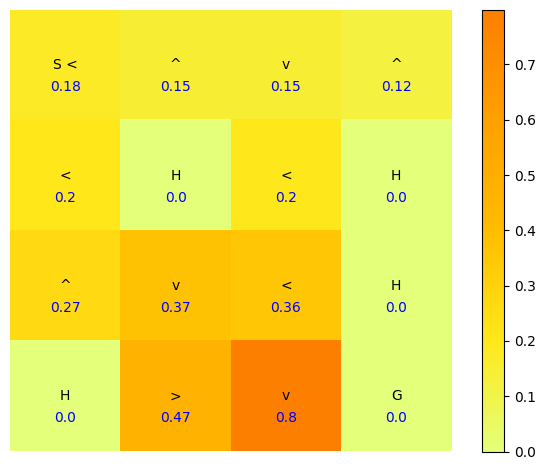

In [22]:
# visualisation de la table Q pour FrozenLake 
def plotQ(q_table,env):
  MAP=env.desc
  map_size=MAP.shape[0]
  best_value = np.max(q_table, axis = 1).reshape((map_size,map_size))
  best_policy = np.argmax(q_table, axis = 1).reshape((map_size,map_size))
    
  fig, ax = plt.subplots()
  im = ax.imshow(best_value,cmap=plt.cm.Wistia)#Pastel1, spring, autumn
  arrow_list=['<','v','>','^']
  for i in range(best_value.shape[0]):
      for j in range(best_value.shape[1]):
          if MAP[i][j].decode('utf-8') in 'GH':#terminal states
            arrow = MAP[i][j].decode('utf-8')
          else :
            arrow=arrow_list[best_policy[i, j]]
          if MAP[i][j].decode('utf-8') in 'S':
              arrow = 'S ' + arrow
          text = ax.text(j, i, arrow, ha = "center", va = "center",
                         color = "black")
          text2 = ax.text(j, i+0.2, str(np.round(best_value[i,j],2)), 
                          ha = "center", va = "center",color = "blue")
          
            
  cbar = ax.figure.colorbar(im, ax = ax)
  plt.axis('off')  
  fig.tight_layout()
  plt.show() 

plotQ(Q,env)

In [10]:
#print(qtable)
#np.max(qtable, axis = 1).reshape((4,4))
#look at https://gsverhoeven.github.io/post/frozenlake-qlearning-convergence/ for the optimal value function

## Use the Q-table to play FrozenLake
- After 10 000 episodes, our Q-table can be used as a "cheatsheet" to play FrozenLake"
- By running this cell you can see our agent playing FrozenLake.

****************************************************
EPISODE  0
Number of steps 12
****************************************************
EPISODE  1
Number of steps 30
****************************************************
EPISODE  2
Number of steps 29
****************************************************
EPISODE  3
Number of steps 20
****************************************************
EPISODE  4
Number of steps 38
****************************************************
EPISODE  5
Number of steps 31
****************************************************
EPISODE  6
Number of steps 24
****************************************************
EPISODE  7
Number of steps 57
****************************************************
EPISODE  8
Number of steps 55
****************************************************
EPISODE  9
Number of steps 54
Score over time: 0.7


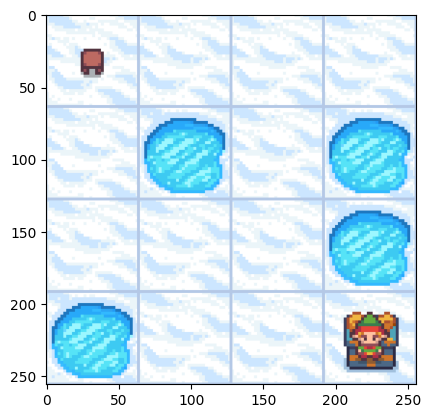

In [23]:
env.reset()
rewards = []
n_test_epoch=10

for _episode in range(n_test_epoch):
    state, _ = env.reset()
    epoch_reward = 0

    print("****************************************************")
    print("EPISODE ", _episode)

    for _step in range(n_step):
        
        # Take the action (index) that have the maximum expected future reward given that state
        action = np.argmax(Q[state,:])
        #env.render()

        new_state, new_reward, terminated, _, _ = env.step(action)
        epoch_reward += new_reward  

        if terminated:
            screen = env.render()
            if len(screen)>0: plt.imshow(screen)
            print("Number of steps", _step)
            break

        state = new_state

    rewards.append(epoch_reward)

print ("Score over time: " +  str(sum(rewards)/n_test_epoch))

env.close()

## Questions

- is the obtained value function optimal ?
- is the obtained policy optimal ?
- when $\gamma$ goes to $1.0$ do the policy changes ? 
- change the total number of training episodes 
- implement Double Q-learning ...
